In [1]:
#%%
import re
import os
# add the parent directory to the path
import sys
sys.path.append('../../')
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal
from utils import *
import seaborn as sns

folder_path = '../experiment_data/tk_11092023'

exp_layout = {0:(0,['B','C','D']),
              10**-2:(0,['E','F','G']),
              10**-1:(1,['B','C','D']),
              10**0:(1,['E','F','G']),
              10**1:(2,['B','C','D']),
              10**2:(2,['E','F','G'])}

# These functions help with sorting the file names in natural order
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


rfu30_to_dilution = cal.run()

In [2]:
def get_timeseries(folder_path,plate_num):
    """Takes a folder of excel files and returns a list of plates and a list of data
    Each element in the list corresponds to a plate scan.
    Specify plate num to get the data from a specific excel sheet.

    Args:
        folder_path (str): path to the folder containing the excel files
        plate_num (int): the excel sheet number corresponding to the plate

    Returns:
        list: list of plate objects
        list: list of dictionaries containing the data
    """
    plate_files = os.listdir(folder_path)

    # filter and sort the files
    plate_files = [p for p in plate_files if p.endswith('.xlsx')]
    plate_files.sort(key=natural_keys)

    plates = []
    data = []
    for plate_file in plate_files:
        if plate_file[0] != '~': # ignore temporary files
            path_t = os.getcwd() + os.sep + folder_path + os.sep + plate_file # path to the excel file

            # get a plate object corresponding to the excel file
            p = AutoRate.Plate(path_t,mode='single_measurement',sheet_name=plate_num)
            plates.append(p)

            # put the data in dictionary format with keys corresponding to the well names 
            data.append(p.od_data_to_dict(p.data))
            
    return plates,data

In [3]:
# re-format data into dictionary with keys corresponding to genotypes
# elements of the dicts are timeseries data

mean_dict = {} # mean fluorescence
err_dict = {} # standard error of the mean

cell_count_raw = {}
cell_count_mean = {} # mean cell count
cell_count_err = {} # standard error of the mean
cell_count_log_err = {} # standard error of the mean of the log

# B-D and E-G are replicates

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,10))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key]
            # col_indx += 1
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)

    cell_count_data = rfu30_to_dilution(data_t,background_subtracted=False)
    cell_count_mean[exp_key] = np.mean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.std(cell_count_data,axis=0)
    cell_count_log_err[exp_key] = np.std(np.log10(cell_count_data),axis=0)
    cell_count_raw[exp_key] = cell_count_data

# get the sample times

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)

dict_t = {'time':time,
          'mean':mean_dict,
          'err':err_dict,
          'cell_count_mean':cell_count_mean,
          'cell_count_err':cell_count_err,
          'cell_count_log_err':cell_count_log_err}

# save as pickle

with open('data_11092023.pickle','wb') as f:
    pickle.dump(dict_t,f)

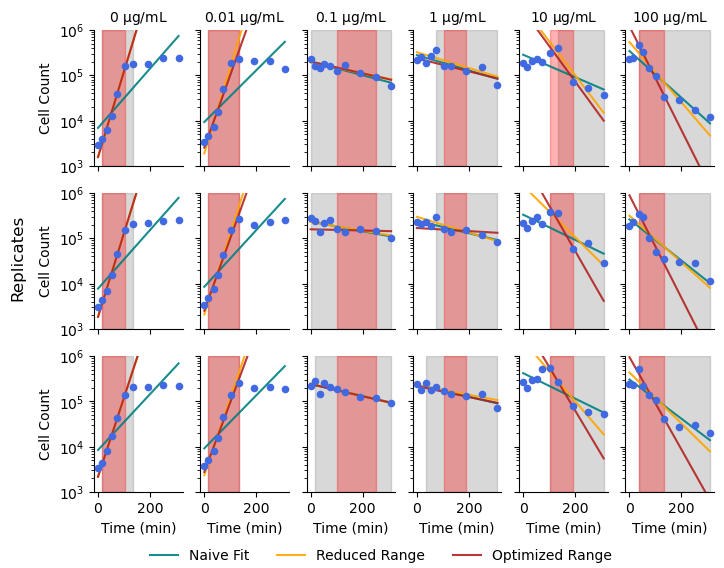

In [4]:
n_replicates = 3
n_conditions = len(cell_count_mean.keys())

fig,ax_list = plt.subplots(nrows=n_replicates,ncols=n_conditions,figsize=(8,6),sharex=True,sharey=True)

lin_range_dict = {}
naive_range_dict = {}
naive_reg_dict = {}

exclude = 1

row_indx = 0

for key in cell_count_mean.keys():

    slope_est = []
    slope_err = []

    naive_slope_est = []
    naive_slope_err = []

    for i in range(n_replicates):

        X = time
        Y = cell_count_raw[key][i]

        # compute naive linear regression

        res = stats.linregress(X,np.log10(Y))
        naive_slope_est.append(res.slope*60)

        # compute RSS
        st_err = 0
        indx = 0
        for t in X:
            est = 10**(res.slope*t + res.intercept)
            y_t = Y[indx]
            st_err += (y_t - est)**2
            indx += 1
        naive_slope_err.append(st_err)

        if Y[-1] > Y[0]:
            start_indx = exclude
            end_indx = 6
        else:
            start_indx = np.argwhere(Y == np.max(Y))[0][0]
            end_indx = -1

        ax = ax_list[i,row_indx]

        ax.scatter(X,Y,color='royalblue',alpha=1,s=20,zorder=10)

        X_fit = np.linspace(np.min(time),np.max(time),100)
        Y_fit = 10**(res.slope*X_fit + res.intercept)

        ax.plot(X_fit,Y_fit,color='teal',alpha=0.9,label='Naive Fit')

        ax.axvspan(X[start_indx],X[end_indx],color='gray',alpha=0.3,zorder=-10)

        res = stats.linregress(X[start_indx:end_indx],np.log10(Y[start_indx:end_indx]))

        X_t = X[start_indx:end_indx]
        Y_t = Y[start_indx:end_indx]

        st_err = 0
        indx = 0
        for t in X_t:
            est = 10**(res.slope*t + res.intercept)
            y_t = Y_t[indx]
            st_err += (y_t - est)**2
            indx += 1

        slope_err.append(st_err)

        Y_fit = 10**(res.slope*X_fit + res.intercept)

        ax.plot(X_fit,Y_fit,color='orange',alpha=0.9,label='Reduced Range')

        slope_est.append(res.slope*60)

    dict_t = {'mean':np.mean(slope_est),
              'err':np.std(slope_est),
              'std_err':np.sum(slope_err)}
    
    naive_range_dict[key] = dict_t

    dict_t = {'mean':np.mean(naive_slope_est),
                'err':np.std(naive_slope_est),
                'std_err':np.sum(naive_slope_err)}
    
    naive_reg_dict[key] = dict_t

    X = (time - np.min(time))/(np.max(time) - np.min(time))
    X = X[exclude:]

    Y = np.log10(cell_count_mean[key])[exclude:]
    Y = (Y - np.min(Y))/(np.max(Y) - np.min(Y))

    # ax = ax_list[i]
    # ax.plot(X,Y)

    # determine upper and lower bounds for the slope
    if Y[-1] > Y[0]:
        slope_ub = np.inf
        slope_lb = 0.01
    else:
        slope_ub = 0
        slope_lb = -np.inf

    lin_range = opt_linear_range(X,Y,1,slope_ub=slope_ub,slope_lb=slope_lb)

    slope_est = []
    slope_err = []

    for i in range(n_replicates):
        ax = ax_list[i,row_indx]
        
        X = time
        Y = cell_count_raw[key][i]

        # ax.scatter(X,Y,color='steelblue',alpha=1,s=20)

        ax.axvspan(X[lin_range[0]+exclude],X[lin_range[1]-1+exclude],color='red',alpha=0.3,zorder=-10)

        X_reg = X[lin_range[0]+exclude:lin_range[1]+exclude]
        Y_reg = Y[lin_range[0]+exclude:lin_range[1]+exclude]

        res = stats.linregress(X_reg,np.log10(Y_reg))

        X_fit = np.linspace(np.min(time),np.max(time),100)
        Y_fit = 10**(res.slope*X_fit + res.intercept)

        ax.plot(X_fit,Y_fit,color='firebrick',alpha=0.9,label='Optimized Range')

        # compute standard error
        X_t = X[start_indx:end_indx]
        Y_t = Y[start_indx:end_indx]

        st_err = 0
        indx = 0
        for t in X_t:
            est = 10**(res.slope*t + res.intercept)
            y_t = Y_t[indx]
            st_err += (y_t - est)**2
            indx += 1

        slope_err.append(st_err)

        if key == 0 or key == 10**-2:
            ax.set_ylim(10**3,0.3*10**6)
        else:
            ax.set_ylim(10**3,0.5*10**6)

        slope_est.append(res.slope*60)

    dict_t = {'mean':np.mean(slope_est),
              'err':np.std(slope_est),
              'std_err':np.sum(st_err)}
    lin_range_dict[key] = dict_t

    row_indx += 1

for ax in ax_list.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_yticks([])
    ax.set_yscale('log')

    ax.set_ylim(10**3,10**6)

for ax in ax_list[:,0]:
    ax.set_ylabel('Cell Count')

for ax in ax_list[-1,:]:
    ax.set_xlabel('Time (min)')

for key,i in enumerate(cell_count_mean.keys()):
    ax_list[0,key].set_title(str(i) + ' $\mathrm{\mu g/mL}$',fontsize=10)


# get the unique legend elements
handles, labels = ax_list[0,0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc=[0.2,0],ncol=3,frameon=False)

fig.text(0.02,0.5, 'Replicates', va='center', rotation='vertical',fontsize=12)

fig.savefig('../../figures/raw_data_with_fit.pdf',bbox_inches='tight')

In [5]:
np.std(slope_est)

0.033744808342444414

In [6]:
auc_dict = {}

for key in cell_count_mean.keys():

    auc_est = []
    for i in range(n_replicates):
        y = np.log10(cell_count_raw[key][i])
        y = y/y[0]
        auc_est.append(np.trapz(time,y))
    
    dict_t = {'avg':np.mean(auc_est),'err':np.std(auc_est)}
    auc_dict[key] = dict_t

# normalize for conc = 0
max_auc = auc_dict[0]['avg']
for key in auc_dict.keys():
    auc_dict[key]['mean'] = auc_dict[key]['avg']/max_auc
    auc_dict[key]['err'] = auc_dict[key]['err']/max_auc

/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_9276/2069742604.py:21: RuntimeWarning: invalid value encountered in scalar power
  g.append(gmax - (((gmax-gmin)*(c_t/mic)**k)/((c_t/mic)**k-(gmin/gmax))))


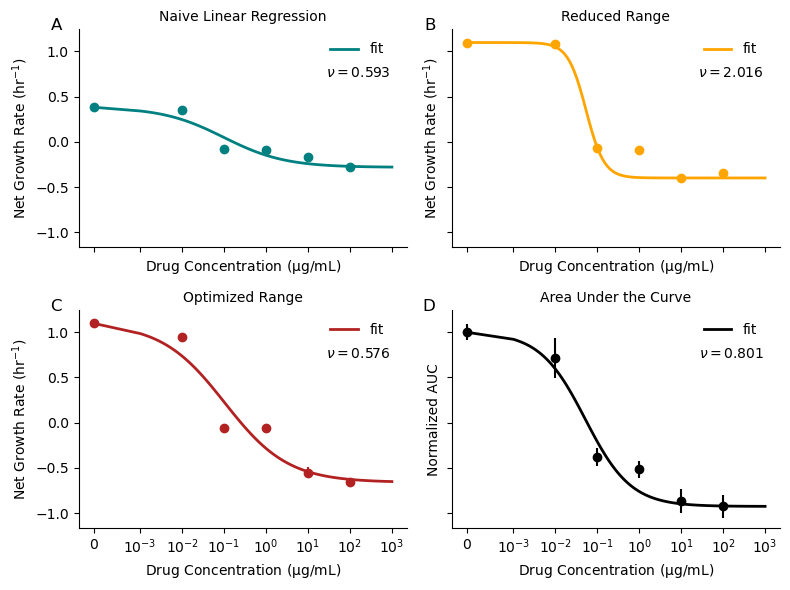

In [7]:
def pharmacodynamic_curve(c, gmax, gmin, mic, k):
    """pharmacodynamic model adapted from Foerster et al.

    Foerster, S., Unemo, M., Hathaway, L.J. et al. Time-kill curve analysis and
    pharmacodynamic modelling for in vitro evaluation of antimicrobials against Neisseria
    gonorrhoeae . BMC Microbiol 16, 216 (2016). 
    https://doi.org/10.1186/s12866-016-0838-9

    Args:
        c (float): drug concentration
        gmax (float): max growth rate
        gmin (float): min growth rate
        mic (float): estimated minimum inhibitory concentration
        k (float): hill coefficient
    """
    g = []
    for c_t in c:
        if c_t == 0:
            g.append(gmax)
        else:
            g.append(gmax - (((gmax-gmin)*(c_t/mic)**k)/((c_t/mic)**k-(gmin/gmax))))
    
    return g

fig,ax_list = plt.subplots(ncols=2,nrows=2,figsize=(8,6),sharex=True,sharey=True)

pd_est_methods = [naive_reg_dict,naive_range_dict,lin_range_dict,auc_dict]
titles = ['Naive Linear Regression','Reduced Range','Optimized Range','Area Under the Curve']
ylabels = ['Net Growth Rate (hr$^{-1}$)','Net Growth Rate (hr$^{-1}$)','Net Growth Rate (hr$^{-1}$)','Normalized AUC']
color_list = ['teal','orange','firebrick','k']

for i,dict_t in enumerate(pd_est_methods):
    
        gr_mean = np.array([dict_t[key]['mean'] for key in dict_t.keys()])
        err_vect = np.array([dict_t[key]['err'] for key in dict_t.keys()])

        if 'std_err' in dict_t[0].keys():
            mean_rss = np.array([dict_t[key]['std_err'] for key in dict_t.keys()])
            mean_rss = np.mean(mean_rss)
            mean_rss = '{:.0e}'.format(mean_rss)
        else:
            mean_rss = 'na'
    
        ax = ax_list.flatten()[i]
    
        ax.errorbar(dict_t.keys(),gr_mean,yerr=err_vect,fmt='o',color=color_list[i],alpha=1)
    
        conc_list = np.array(list(dict_t.keys()))
    
        gmin = np.min(gr_mean)
        gmax = np.max(gr_mean)
    
        p0 = [1,0.1]
        popt,pcov = curve_fit(lambda x, mic,k: pharmacodynamic_curve(x,gmax,gmin,mic,k),
                                conc_list,gr_mean,p0=p0,maxfev=100000)
    
        conc_fit = np.logspace(-3,3,100)
        # append 0 to the beginning of the array
        conc_fit = np.insert(conc_fit,0,0)
        gr_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,popt[0],popt[1])
    
        gr_fit = np.array(gr_fit)
    
        ax.plot(conc_fit,gr_fit,color=color_list[i],alpha=1,linewidth=2,zorder=-1,label='fit')
    
        ax.set_xscale('symlog',linthresh=0.001)
    
        ax.legend(frameon=False,loc=[0.75,0.85])
        ax.set_xlabel('Drug Concentration ($\mathrm{\mu}$g/mL)')
        ax.set_ylabel(ylabels[i])
        ax.set_title(titles[i],fontsize=10) 

        # get the coordinate of the right corner of the legend
        
        ax.annotate('$\\nu = $' + str(round(popt[1],3)),(0.95,0.8),xycoords='axes fraction',ha='right',va='center')
        # ax.annotate('Mean $RSS$ = ' + mean_rss,(0.95,0.7),xycoords='axes fraction',ha='right',va='center')
    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

labels = ['A','B','C','D']

for i,ax in enumerate(ax_list.flatten()):
    ax.text(-0.05, 1.05, labels[i], transform=ax.transAxes,fontsize=12, va='top', ha='right')

fig.tight_layout()

fig.savefig('../../figures/pharmacodynamic_fit.pdf',bbox_inches='tight')

[1.0987917282221435, -0.659298413489605, 0.25245608901653493, 0.5757451749816003]


/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_9276/2069742604.py:21: RuntimeWarning: invalid value encountered in scalar power
  g.append(gmax - (((gmax-gmin)*(c_t/mic)**k)/((c_t/mic)**k-(gmin/gmax))))


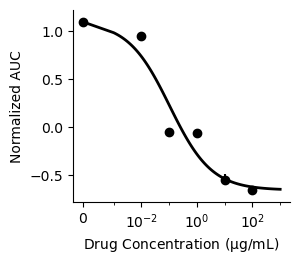

In [8]:
fig,ax = plt.subplots(figsize=(2.8,2.5))

dict_t = lin_range_dict

gr_mean = np.array([dict_t[key]['mean'] for key in dict_t.keys()])
err_vect = np.array([dict_t[key]['err'] for key in dict_t.keys()])

if 'std_err' in dict_t[0].keys():
    mean_rss = np.array([dict_t[key]['std_err'] for key in dict_t.keys()])
    mean_rss = np.mean(mean_rss)
    mean_rss = '{:.0e}'.format(mean_rss)
else:
    mean_rss = 'na'

ax.errorbar(dict_t.keys(),gr_mean,yerr=err_vect,fmt='o',color=color_list[i],alpha=1)

conc_list = np.array(list(dict_t.keys()))

gmin = np.min(gr_mean)
gmax = np.max(gr_mean)

p0 = [1,0.1]
popt,pcov = curve_fit(lambda x, mic,k: pharmacodynamic_curve(x,gmax,gmin,mic,k),
                        conc_list,gr_mean,p0=p0,maxfev=100000)

conc_fit = np.logspace(-3,3,100)
# append 0 to the beginning of the array
conc_fit = np.insert(conc_fit,0,0)
gr_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,popt[0],popt[1])

gr_fit = np.array(gr_fit)

ax.plot(conc_fit,gr_fit,color=color_list[i],alpha=1,linewidth=2,zorder=-1,label='fit')

ax.set_xscale('symlog',linthresh=0.001)

# ax.legend(frameon=False,loc=[0.75,0.85])
ax.set_xlabel('Drug Concentration ($\mathrm{\mu}$g/mL)')
ax.set_ylabel(ylabels[i])

ax.set_xticks([0,10**-2,10**0,10**2])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig('../../figures/pharmacodynamic_fit_small.pdf',bbox_inches='tight')

print([gmax,gmin,popt[0],popt[1]])

/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_9276/2069742604.py:21: RuntimeWarning: invalid value encountered in scalar power
  g.append(gmax - (((gmax-gmin)*(c_t/mic)**k)/((c_t/mic)**k-(gmin/gmax))))


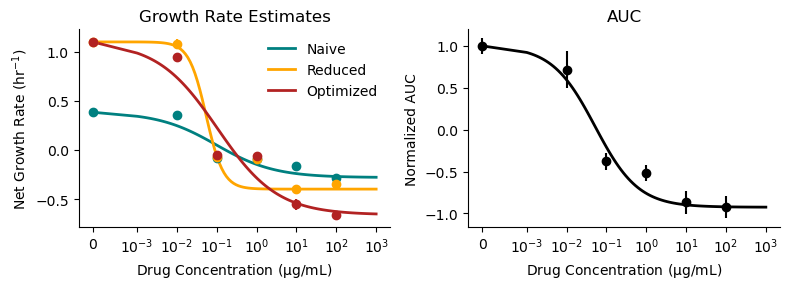

In [9]:
fig,ax_list = plt.subplots(ncols=2,figsize=(8,3))

pd_est_methods = [naive_reg_dict,naive_range_dict,lin_range_dict]
titles = ['Naive','Reduced','Optimized','Area Under the Curve']
ylabels = ['Net Growth Rate (hr$^{-1}$)','Net Growth Rate (hr$^{-1}$)','Net Growth Rate (hr$^{-1}$)','Normalized AUC']
color_list = ['teal','orange','firebrick','k']

ax = ax_list[0]

for i,dict_t in enumerate(pd_est_methods):
    
        gr_mean = np.array([dict_t[key]['mean'] for key in dict_t.keys()])
        err_vect = np.array([dict_t[key]['err'] for key in dict_t.keys()])

        if 'std_err' in dict_t[0].keys():
            mean_rss = np.array([dict_t[key]['std_err'] for key in dict_t.keys()])
            mean_rss = np.mean(mean_rss)
            mean_rss = '{:.0e}'.format(mean_rss)
        else:
            mean_rss = 'na'
    
        ax.errorbar(dict_t.keys(),gr_mean,yerr=err_vect,fmt='o',color=color_list[i],alpha=1)
    
        conc_list = np.array(list(dict_t.keys()))
    
        gmin = np.min(gr_mean)
        gmax = np.max(gr_mean)
    
        p0 = [1,0.1]
        popt,pcov = curve_fit(lambda x, mic,k: pharmacodynamic_curve(x,gmax,gmin,mic,k),
                                conc_list,gr_mean,p0=p0,maxfev=100000)
    
        conc_fit = np.logspace(-3,3,100)
        # append 0 to the beginning of the array
        conc_fit = np.insert(conc_fit,0,0)
        gr_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,popt[0],popt[1])
    
        gr_fit = np.array(gr_fit)
    
        ax.plot(conc_fit,gr_fit,color=color_list[i],alpha=1,linewidth=2,zorder=-1,label=titles[i])
    
        ax.set_xscale('symlog',linthresh=0.001)
    
        ax.legend(frameon=False)
        ax.set_xlabel('Drug Concentration ($\mathrm{\mu}$g/mL)')
        # ax.set_ylabel(ylabels[i])
        # ax.set_title(titles[i],fontsize=10) 

        # get the coordinate of the right corner of the legend
        
        # ax.annotate('$\\nu = $' + str(round(popt[1],3)),(0.95,0.8),xycoords='axes fraction',ha='right',va='center')
        # ax.annotate('Mean $RSS$ = ' + mean_rss,(0.95,0.7),xycoords='axes fraction',ha='right',va='center')
    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    
ax = ax_list[1]

dict_t = auc_dict

gr_mean = np.array([dict_t[key]['mean'] for key in dict_t.keys()])
err_vect = np.array([dict_t[key]['err'] for key in dict_t.keys()])

if 'std_err' in dict_t[0].keys():
    mean_rss = np.array([dict_t[key]['std_err'] for key in dict_t.keys()])
    mean_rss = np.mean(mean_rss)
    mean_rss = '{:.0e}'.format(mean_rss)
else:
    mean_rss = 'na'

ax.errorbar(dict_t.keys(),gr_mean,yerr=err_vect,fmt='o',color='k',alpha=1)

conc_list = np.array(list(dict_t.keys()))

gmin = np.min(gr_mean)
gmax = np.max(gr_mean)

p0 = [1,0.1]
popt,pcov = curve_fit(lambda x, mic,k: pharmacodynamic_curve(x,gmax,gmin,mic,k),
                        conc_list,gr_mean,p0=p0,maxfev=100000)

conc_fit = np.logspace(-3,3,100)
# append 0 to the beginning of the array
conc_fit = np.insert(conc_fit,0,0)
gr_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,popt[0],popt[1])

gr_fit = np.array(gr_fit)

ax.plot(conc_fit,gr_fit,color='k',alpha=1,linewidth=2,zorder=-1)

ax.set_xscale('symlog',linthresh=0.001)

ax.set_xlabel('Drug Concentration ($\mathrm{\mu}$g/mL)')
# ax.set_ylabel(ylabels[i])
# ax.set_title(titles[i],fontsize=10) 

# get the coordinate of the right corner of the legend

# ax.annotate('$\\nu = $' + str(round(popt[1],3)),(0.95,0.8),xycoords='axes fraction',ha='right',va='center')
# ax.annotate('Mean $RSS$ = ' + mean_rss,(0.95,0.7),xycoords='axes fraction',ha='right',va='center')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_list[0].set_ylabel('Net Growth Rate (hr$^{-1}$)')
ax_list[1].set_ylabel('Normalized AUC')

ax_list[0].set_title('Growth Rate Estimates')
ax_list[1].set_title('AUC')

fig.tight_layout()

In [10]:
err_vect

array([0.09060401, 0.22066359, 0.09639869, 0.09444368, 0.13222526,
       0.13046335])